## Indroduction

- This notebook consists code for the feature creation from structured data using CNN technique

##### Here the business objective is to predict the probability of credit default based on credit card owner’s payment status, balance and payment history monitored for past few vintages(last 6 months from the predicted period)

In [16]:
#Required Packages

import librosa
import librosa.display
import scipy.io.wavfile
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model,load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import cv2
from glob import glob
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import tqdm
import cv2
from keras import applications,models, losses,optimizers
from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
import numpy as np
import keras.backend as K
from scipy.spatial import distance
from PIL import Image
from keras.preprocessing import image
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm,tqdm_pandas
import seaborn as sns

*We need to first segregate the data first into retail_card and mortgage with 30k observation(unique cust ID)each*

- *The The original dataset was consisting of one trade- retail card and is souced from [here](https://medium.com/@guaisang/credit-default-prediction-with-logistic-regression-b5bd89f2799f). To make it more relevant and more challenging I created dummy datasets for additional trade – mortgage* 

In [13]:
#Data Load

os.chdir('D:/data_science/cnn_feature')
data = pd.read_csv('CreditDefault.csv')
ID = data['ID'].unique()
retail_card = data.iloc[0:30000,:]
retail_card = retail_card.drop(['ID'], axis =1)
mortgage = data.iloc[30000:60000,:]
mortgage = mortgage.drop(['ID'], axis =1)

**Now let's explore the data a bit**

In [6]:
#Columns names and shape
print('no of customers:',len(data['ID'].unique()))
print('shape of retail_card data:', retail_card.shape)
print('shape of mortgage data:', mortgage.shape)
data.columns

no of customers: 30000
shape of retail_card data: (30000, 19)
shape of mortgage data: (30000, 19)


Index(['Unnamed: 0', 'ID', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

**So we have past 6 months data for payment status(PAY), Balance(BILL_AMT) and payment(PAY_AMT) for each customer**

*Let's look at event rate(default payment next month)*

In [23]:
event_id = pd.read_csv('train.csv')
print(event_id['default payment next month'].value_counts())
print('payment default rate is: %f percent' %((event_id['default payment next month'].value_counts()[1]/event_id['default payment next month'].value_counts()[0]) * 100))

0    23364
1     6636
Name: default payment next month, dtype: int64
payment default rate is: 28.402671 percent


**Although event rate is not 50%, we can say it's fairly balanced data. so no need to do any weight correction**

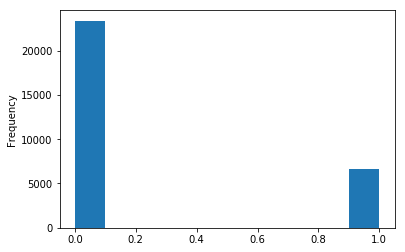

In [53]:
event_id['default payment next month'].astype(int).plot.hist()

In [43]:
mortgage.index = retail_card.index

### Now the most crucial part is to prepare the data in the format(image like format), so that we can apply CNN

#### Precisely for our data the dimension for each customer will be 3(no of feature) * 6(time horizons) * 2(trades) and there will be 30000 frames of this dimension.

- So for the entire data it will be an array of will be 30000 * 3(width) *6(depth) * 2(no of channels). So the data will be perfect to train a Convolutional network.

In [44]:
#preparing channel specific data

#Retail
retail = []
for i in tqdm(range(retail_card.shape[0])):
    pay = retail_card.loc[i,['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].values

    bill = retail_card.loc[i,['BILL_AMT1',	'BILL_AMT2','BILL_AMT3',	'BILL_AMT4','BILL_AMT5',	'BILL_AMT6']].values
    pay_amt = retail_card.loc[i,['PAY_AMT1',	'PAY_AMT2',	'PAY_AMT3',	'PAY_AMT4','PAY_AMT5','PAY_AMT6']].values
    a = np.vstack((pay,bill,pay_amt))
    a = a.tolist()
    retail.append(a)
retail = np.array(retail)
retail = np.reshape(retail,(retail.shape[0],3,6,1))

#Mortgage
mort = []
for i in tqdm(range(mortgage.shape[0])):
    pay = mortgage.loc[i,['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']].values

    bill = mortgage.loc[i,['BILL_AMT1',	'BILL_AMT2','BILL_AMT3',	'BILL_AMT4','BILL_AMT5',	'BILL_AMT6']].values
    pay_amt = mortgage.loc[i,['PAY_AMT1',	'PAY_AMT2',	'PAY_AMT3',	'PAY_AMT4','PAY_AMT5','PAY_AMT6']].values
    a = np.vstack((pay,bill,pay_amt))
    a = a.tolist()
    mort.append(a)
mort = np.array(mort)
mort = np.reshape(mort,(mort.shape[0],3,6,1))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:15<00:00, 398.64it/s]


### Channel specific Data prepared, now let's check the dimention

In [45]:
print('shape of channel1(retail)data:', retail.shape)
print('shape of channel2(mortgage)data:', mort.shape)

shape of channel1(retail)data: (30000, 3, 6, 1)
shape of channel2(mortgage)data: (30000, 3, 6, 1)


## Input and Output for CNN

### We have to concatenate these two array to prepare the input volume for CNN. This will the input layer for CNN
### Also we need to prepare target variable in one Hot Encoding format

In [46]:
#IV-DV prepare

X = np.concatenate((retail, mort),axis=3)
Y = event_id[['default payment next month']].values
Y = to_categorical(Y,2)

- ### Now time to build a light CNN. I will use keras framework with backend as tensorflow(tf).

   - #### For our business problem AUC is the evaluation metric. Although we are not building the end model model the the filter      weights will be updated properly and network training will be ideal to extract 100 features, which can capture the         relationship between input variables and target variable its best. Keras doesn't have default AUC metric. However we can leverage tf to create customized evaluation function for auc.        

In [47]:
#AUC function

import tensorflow as tf
from keras import backend as K
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

## CNN architecture

   - First we make the complete CNN model using last dense layer(here dimension 2).The objective of training network is to identify the correct weights for the network by multiple forward and backward iterations.
   - By using pre-trained models, we can directly use the weights and architecture obtained and apply these weights on a data removing the last sigmoid/logistic layer(in this problem till dense layer of dimension 100).We can apply this to any new data of same business problem to calculate these features.We need to just feed forward the network and it will directly map final weights to calculate features at the final layer, without building the network again.This is a kind of transfer learning.Based on our requirement of no of features we can extract features at any intermediate dense layer with desired dimension.

In [49]:
batch_size = 256
epochs = 100
filepath='keras_model_conv2D'

np.random.seed(1337)          # for reproducibility
print('Building model...')
model = Sequential()
model = Sequential()

#1st conv layer
model.add(Conv2D(32, (4,10), padding="same",
                 input_shape=(X.shape[1],X.shape[2],X.shape[3]),data_format="channels_last"))
model.add(BatchNormalization())
model.add(Activation("relu"))

#2nd conv layer
model.add(Conv2D(32, (4,10), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))

#3rd conv layer
model.add(Conv2D(32, (4,10), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))

#4th conv layer
model.add(Conv2D(32, (4,10), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())

#FC1
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.3))

#FC2
model.add(Dense(100,name ='feature_dense'))
model.load_weights(by_name=True,filepath = filepath)
model.add(BatchNormalization())
model.add(Activation("relu"))

#output FC
model.add(Dense(2))
model.add(Activation('sigmoid'))
adam = optimizers.Adam(lr=0.01)

model.compile(loss='binary_crossentropy', metrics=[auc], optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 3, 6, 32)          2592      
_________________________________________________________________
batch_normalization_6 (Batch (None, 3, 6, 32)          128       
_________________________________________________________________
activation_6 (Activation)    (None, 3, 6, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 6, 32)         3872      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 6, 32)         128       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 6, 32)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 6, 32)         40992     
__________

- **Let's Visualize the architechture**

In [ ]:
#Plot CNN architechture

import pydot
from keras.utils import plot_model
from IPython.display import SVG
import keras.utils.vis_utils 
from keras.utils.vis_utils import model_to_dot
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

#### - ** Now we will train the model for epochs = 100. We will utilize early stopping to prevent overfitting, if any.It took less than 5 mins time to train using my NVIDIA GTX GeForce 1060 GPU with best val_auc: 0.8317**

In [ ]:
early_stops = EarlyStopping(patience=5, monitor='val_auc')
filepath='keras_model_conv2D'
ckpt_callback = ModelCheckpoint(filepath,
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')
    
model.fit(X, Y, validation_split=0.05, callbacks=[early_stops,ckpt_callback], 
                        batch_size=batch_size, epochs=epochs)
model.save('keras_model_conv2D.h5')

Train on 28500 samples, validate on 1500 samples
Epoch 1/100


##### Now we will extract feature using intermediate model till 'feature_dense' layer for input data. 

  - ###### First we need to check the output dense layer dimension of intermediate_layer_model      

In [9]:
#Preparing Indermediate model

os.chdir('D:/data_science/cnn_feature')

model = load_model('keras_model_conv2D.h5')
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('feature_dense').output)
intermediate_layer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98_input (InputLayer) (None, 3, 6, 2)           0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 3, 6, 32)          2592      
_________________________________________________________________
batch_normalization_140 (Bat (None, 3, 6, 32)          128       
_________________________________________________________________
activation_149 (Activation)  (None, 3, 6, 32)          0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 32, 6, 32)         3872      
_________________________________________________________________
batch_normalization_141 (Bat (None, 32, 6, 32)         128       
_________________________________________________________________
activation_150 (Activation)  (None, 32, 6, 32)         0         
__________

*Yes we are almost done.The output layer dimension is 100, so if we predict using this netowork on a new data with 
same input dimension, we can create 100 new complex features.*

In [12]:
#predict to get featured data

feauture_engg_data = intermediate_layer_model.predict(X)
feauture_engg_data = pd.DataFrame(feauture_engg_data)
print('feauture_engg_data shape:', feauture_engg_data.shape)
feauture_engg_data.head(5)  #The features are unnamed now

feauture_engg_data shape: (30000, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-2.279314,1.178664,0.574329,-1.169564,-0.720348,-1.545350,-0.509746,0.069629,-0.607492,1.511342,...,0.490457,0.732884,-1.250946,-0.242123,0.300502,-0.940489,-2.939329,-2.253297,-2.367808,0.650523
1,-2.284362,0.830985,1.149805,-1.223606,-0.794857,-1.358322,-0.233224,0.447545,-0.299049,2.115453,...,-0.094006,0.096930,-0.889044,-0.388074,0.126496,-1.133084,-2.846876,-2.197683,-2.582960,0.469175
2,-1.342703,1.201362,0.890467,-1.023844,-0.898835,0.169773,-0.789533,-0.103844,-0.590606,0.896959,...,-0.529201,0.464623,-0.405276,0.017227,0.260931,-1.019717,-1.338941,-2.184509,-0.954673,0.191375
3,-2.262624,2.233009,-0.239887,-1.776682,-1.208813,-0.803015,-2.097943,-1.210980,-1.949661,-0.599418,...,1.068820,2.045074,-0.925260,0.397628,1.709614,-1.091027,-2.254990,-2.639364,-2.037529,0.722604
4,-2.130725,0.819645,3.103212,-2.296316,-1.744753,0.447689,0.790025,1.403089,0.059782,4.138971,...,-2.754107,-1.139683,0.029716,-0.507231,-0.400700,-2.841360,-2.121911,-3.746274,-2.225718,0.737023


- Bingo!We successfully captured 100 new complex intaraction amongst raw variables successfully. 
Let's have some sneak-peak whether these features has any value. Although there are a few better ways, for sake of simplicity let's capture some bivariate relationship of these new feature with target variable 'default payment next month'.

- Although for categorical target variable Correlation is not 100% correct method, we will calculate the correlation of all new values with the target as an approximation of the variables which may be important for final model.  

In [14]:
# Renaming columns
new_col = []
for i in range(100):
    new_col.append('feat_%d'%(i+1))
feauture_engg_data.columns = new_col
feauture_engg_data.to_csv('100_feature.csv', index = False)
#To compare predictivetive strength of new variables,let's merge the original data(retail_cards)with the feauture_engg_data and sort Correlation values     
retail_card = pd.concat([retail_card, feauture_engg_data], axis = 1)

# List of new correlations
new_corrs = []
# Iterate through the columns 
for col in retail_card.columns:
    # Calculate correlation with the target
    corr = event_id['default payment next month'].corr(retail_card[col])
    
    # Append the list as a tuple
    new_corrs.append((col, corr))

new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)

#Let's see top 10 correlation values
new_corrs[:10]    

[('PAY_1', 0.32479372847862253),
 ('PAY_2', 0.26355120167216467),
 ('PAY_3', 0.2352525137249163),
 ('feat_78', -0.22173805212223915),
 ('PAY_4', 0.21661363684242424),
 ('PAY_5', 0.20414891387616674),
 ('feat_86', -0.20047655459374053),
 ('feat_6', -0.19189993720885604),
 ('PAY_6', 0.1868663616535449),
 ('feat_3', -0.17394080015462873)]

#### We can see following 4 newly created variables are in top 10, in terms of correlation(pseudo although) with 'default payment next month'. Although based on this nothing concretely can be said about predictive strength of these variable,atleast these variable are worth of further investigation.

  - ##### feat_78(in top-5)
  - ##### feat_86(7th)
  - ##### feat_6(8th)
  - ##### feat_3(10th)
  
    ##### We can also look at the KDE(kernel density estimation) plot of the highest correlated variables, in terms of absolute magnitude correlation.

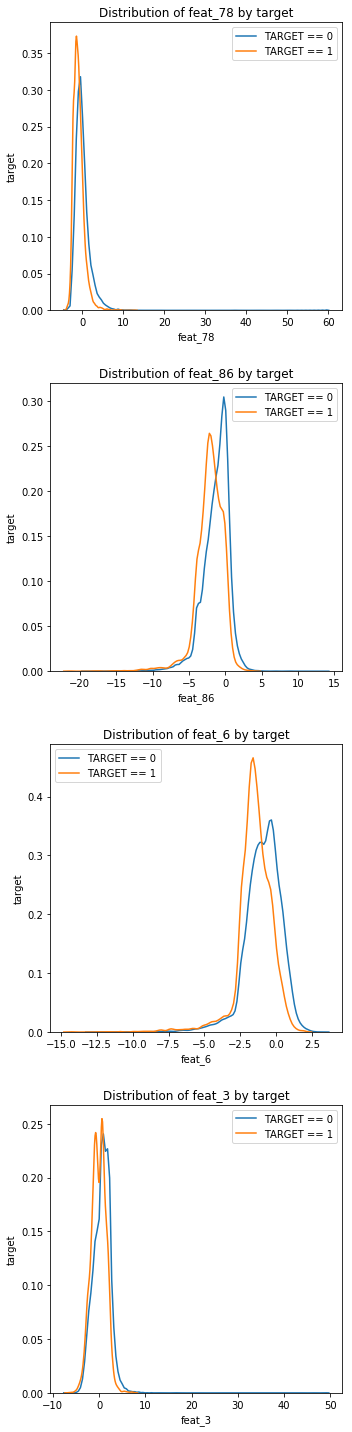

In [20]:
variable = ['feat_78','feat_86','feat_6','feat_3']
event_id = pd.concat([event_id,feauture_engg_data.loc[:,variable]], axis = 1)
plt.figure(figsize=(5,20))
for j, var in enumerate(variable):
    plt.subplot(4,1,j+1)
    sns.kdeplot(event_id.loc[event_id['default payment next month'] == 0,var], label = 'TARGET == 0')
    sns.kdeplot(event_id.loc[event_id['default payment next month'] == 1,var], label = 'TARGET == 1')
    plt.title('Distribution of %s by target' % var)
    plt.xlabel('%s' % var);plt.ylabel('target');
plt.tight_layout(h_pad = 2.5)

#### We can see a weak negative relationship between with the target variable for these variables.Although with this weak correlation may be because of noise,it's worth investing.

### Further Analysis and investigation

- ###### * We can further dig down to get some interpretability of these new features.We will construct a correlation matrix amongst all features to get hunch about these top variable.This will allow us to see if there are highly collinear variables(based on some correllation value threshhold)that should perhaps be removed from the data berore fed into final model.*

- ###### Later, we can perform feature reduction using the feature importances from the model(GBM or any tree based algorithm) or other techniques such as PCA.